In [1]:
import netCDF4 as nc
import glob
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [2]:
#Constants and functions
# Latitude and Longitud were selected while getting the data out of Giovanni Nasa Web Page. This is the matrix of lat and lon selected:
#               lon (E)
#         -104.5   -103.5   -102.5   -101.5   -100.5   
# l  18.5    
# a  19.5
# t  20.5
#(N) 21.5
#
# Since MGZ is in 20.67 N, -103.52 E, lat is index 2 or third value in the array (20.5) and lon is index 1 or second value in the array (-103.5)
lat = 2
lon = 1

#16 rows per year given that each season uses 4 months
rowsPerYear = 16

############ how many years are we looking into ############
extractedYears = 6

#valid start and end dates
VALIDSTARTDATES = [0,1,1,[1,20],1,1,[1,22],1,1,[1,24],1,1,[1,22]]
VALIDENDDATES = [0,1,1,[1,20],1,1,[1,22],1,1,[1,24],1,1,[1,22]]

#Set the plots appearance
plt.rcParams.update({'font.size': 11, 'figure.figsize': (14, 12)}) 


#variable exists in netcdf4 
def variableExists(nc, variable):
    for var in nc.variables:
        if var == variable:
            return True;
    return False;

#get the season name
def getSeasonName(startdate):
    seasonName = ''
    month = startdate.month
    day = startdate.day
    
    if month >= 3 and month < 6:
        if month == 3:
            if day>= 20:
                seasonName = 'SPRING'
            else:
                seasonName = 'WINTER'
        else:
            seasonName = 'SPRING'
    elif month >= 6 and month < 9:
        if month == 6:
            if day>= 20:
                seasonName = 'SUMMER'
            else:
                seasonName = 'SPRING'
        else:
            seasonName = 'SUMMER'
    elif month >=9 and month < 12:
        if month == 9:
            if day>= 20:
                seasonName = 'AUTUMN'
            else:
                seasonName = 'SUMMER'
        else:
            seasonName = 'AUTUMN'
    elif month == 12 and day <20:
        seasonName = 'AUTUMN'
    else:
        seasonName = 'WINTER'
        
    return seasonName


#reduce array
def reduceArray(currValArr, startDateArr, endDateArr, seasonArr):
    reducedValues = {}
    for i in range (len(currValArr)):
        startDate = startDateArr[i]
        endDate = endDateArr[i]
        season = seasonArr[i]
        value = currValArr[i]
        month = startDate.month
        year = startDate.year
        key = str(month)+season+str(year)

        if key in reducedValues:
            reducedValues[key]['value'] = (reducedValues[key]['value'] + value) / 2
            if endDate > reducedValues[key]['endDate']:
                reducedValues[key]['endDate'] = endDate
        else:
            newRow = {
                'value' : value, 
                'startDate' : startDate,
                'endDate' : endDate,
                'season' : season
            }
            reducedValues[key] = newRow

    currValArr = []
    startDateArr = []
    endDateArr = []
    seasonArr = []     

    for row in reducedValues.values():
        currValArr.append(row['value'])
        startDateArr.append(row['startDate'])
        endDateArr.append(row['endDate'])
        seasonArr.append(row['season'])
    
    return currValArr, startDateArr, endDateArr, seasonArr

#Get the file date 
def getFileDates(filename):
    startTimeBit = 'T00:00:00Z'
    endTimeBit = 'T23:59:59Z'
    
    tokens = filename.split('.')
    fileDates = tokens[-3].split('-')
    fileStartDate = pd.to_datetime(fileDates[0]+startTimeBit)
    fileEndDate = pd.to_datetime(fileDates[1]+endTimeBit)
    
    return fileStartDate, fileEndDate
    
#Normalize values of an array from 0 to 1
def normalizeArr(rawArr):
    normArr = np.zeros(len(rawArr))
    npArr = np.array(rawArr)
    maxVal = np.max(npArr)
    minVal = np.min(npArr)
    
    for i in range(len(npArr)):
        normArr = (npArr[i] - minVal) / (maxVal-minVal)
    
    return normArr
    

In [3]:
sensorMeasureName = 'MOD08_D3_6_1_Deep_Blue_Angstrom_Exponent_Land_Mean'
auxSensorMeasureName = 'SWDB_L305_004_angstrom_exponent_land'
path = '../experimentos/alldata/Angstrom Exponent/g4.timeAvgMap.' + sensorMeasureName + '*.nc'

angExpArr = []
startDateArr = []
endDateArr = []
seasonArr = []

for filename in glob.glob(path):
    sensorMeasureName, auxSensorMeasureName = auxSensorMeasureName, sensorMeasureName
    #print(f'Extracting {filename}.')
    
    #getting the netCDF file
    ds = nc.Dataset(filename)
    
    if not variableExists(ds, sensorMeasureName):
        sensorMeasureName, auxSensorMeasureName = auxSensorMeasureName, sensorMeasureName
    
    angExp = float(ds[sensorMeasureName][lat,lon].data)
    startDate = pd.to_datetime(ds.__dict__['start_time'])
    endDate = pd.to_datetime(ds.__dict__['end_time'])
    season = getSeasonName(startDate)
    
    fileStartDate, fileEndDate = getFileDates(filename)
    
    if startDate.day != fileStartDate.day:
        startDate = fileStartDate
    
    if endDate.day != fileEndDate.day:
        endDate = fileEndDate
    
    angExpArr.append(angExp)
    startDateArr.append(startDate)
    endDateArr.append(endDate)
    seasonArr.append(season)
    

#once we have all data into their corresponding arrays, we can proceed to create the dataframe
data = {
    'Angstrom Exponent': angExpArr,
    'Start Date': startDateArr,
    'End Date': endDateArr, 
    'Season': seasonArr
}

dfAngExp = pd.DataFrame(data)

#dfAngExp.isna().sum()

In [4]:
sensorMeasureName = 'MOD08_D3_6_1_Deep_Blue_Aerosol_Optical_Depth_550_Land_Mean'
auxSensorMeasureName = 'SWDB_L305_004_aerosol_optical_thickness_550_land'
path = '../experimentos/alldata/AOD/g4.timeAvgMap.' + sensorMeasureName + '*.nc'

AODArr = []
startDateArr = []
endDateArr = []
seasonArr = []

for filename in glob.glob(path):
    sensorMeasureName, auxSensorMeasureName = auxSensorMeasureName, sensorMeasureName
    #print(f'Now getting data out of {filename}...')
    
    #getting the netCDF file
    ds = nc.Dataset(filename)
    
    if not variableExists(ds, sensorMeasureName):
        sensorMeasureName, auxSensorMeasureName = auxSensorMeasureName, sensorMeasureName
    
    AOD = float(ds[sensorMeasureName][lat,lon].data)
    startDate = pd.to_datetime(ds.__dict__['start_time'])
    endDate = pd.to_datetime(ds.__dict__['end_time'])
    season = getSeasonName(startDate)
    
    fileStartDate, fileEndDate = getFileDates(filename)
    
    if startDate.day != fileStartDate.day:
        startDate = fileStartDate
    
    if endDate.day != fileEndDate.day:
        endDate = fileEndDate
    
    AODArr.append(AOD)
    startDateArr.append(startDate)
    endDateArr.append(endDate)
    seasonArr.append(season)
    

#once we have all data into their corresponding arrays, we can proceed to create the dataframe
data = {
    'AOD': AODArr,
    'Start Date': startDateArr,
    'End Date': endDateArr, 
    'Season': seasonArr
}

dfAOD = pd.DataFrame(data)

In [5]:
sensorMeasureName = 'M2T1NXAER_5_12_4_DUSMASS25'
path = '../experimentos/alldata/Mass Concentration/g4.timeAvgMap.' + sensorMeasureName + '*.nc'

massConcArr = []
startDateArr = []
endDateArr = []
seasonArr = []

for filename in glob.glob(path):
    #print(f'Now getting data out of {filename}...')
    
    #getting the netCDF file
    ds = nc.Dataset(filename)
    
    massConc = float(ds[sensorMeasureName][lat,lon].data)
    startDate = pd.to_datetime(ds.__dict__['start_time'])
    endDate = pd.to_datetime(ds.__dict__['end_time'])
    season = getSeasonName(startDate)
    
    fileStartDate, fileEndDate = getFileDates(filename)
    
    if startDate.day != fileStartDate.day:
        startDate = fileStartDate
    
    if endDate.day != fileEndDate.day:
        endDate = fileEndDate

    massConcArr.append(massConc)
    startDateArr.append(startDate)
    endDateArr.append(endDate)
    seasonArr.append(season)
    

if (len(massConcArr) > rowsPerYear * extractedYears):
    massConcArr, startDateArr, endDateArr, seasonArr = reduceArray(massConcArr, startDateArr, endDateArr, seasonArr)

    
#once we have all data into their corresponding arrays, we can proceed to create the dataframe

data = {
    'Mass Concentration': massConcArr,
    'Start Date': startDateArr,
    'End Date': endDateArr, 
    'Season': seasonArr
}



dfMassConc = pd.DataFrame(data)


In [6]:
#Combinación de DataFrames empleando el método .merge()
comb_df = pd.merge(dfAngExp, dfAOD, on = ['Season', 'Start Date', 'End Date'])

In [7]:
comb_df = pd.merge(comb_df, dfMassConc, on=['Season', 'Start Date', 'End Date'])
#Impresión de los Resultados
print("La combinación de los DataFrames es:")
comb_df.isna().sum()

La combinación de los DataFrames es:


Angstrom Exponent     0
Start Date            0
End Date              0
Season                0
AOD                   0
Mass Concentration    0
dtype: int64

In [ ]:
comb_df.describe()

In [8]:
dfMeasures = comb_df[['Angstrom Exponent', 'AOD', 'Mass Concentration']]
dfMeasures.describe()

,Angstrom Exponent,AOD,Mass Concentration
count,96.000000,96.000000,9.600000e+01
mean,1.407100,0.076259,8.280390e-10
std,0.313710,0.053296,8.103383e-10
min,0.000000,0.000000,6.726109e-11
25%,1.439051,0.034905,2.477545e-10
50%,1.495920,0.058756,5.557237e-10
75%,1.501704,0.108625,1.237500e-09
max,1.648818,0.214000,4.503669e-09


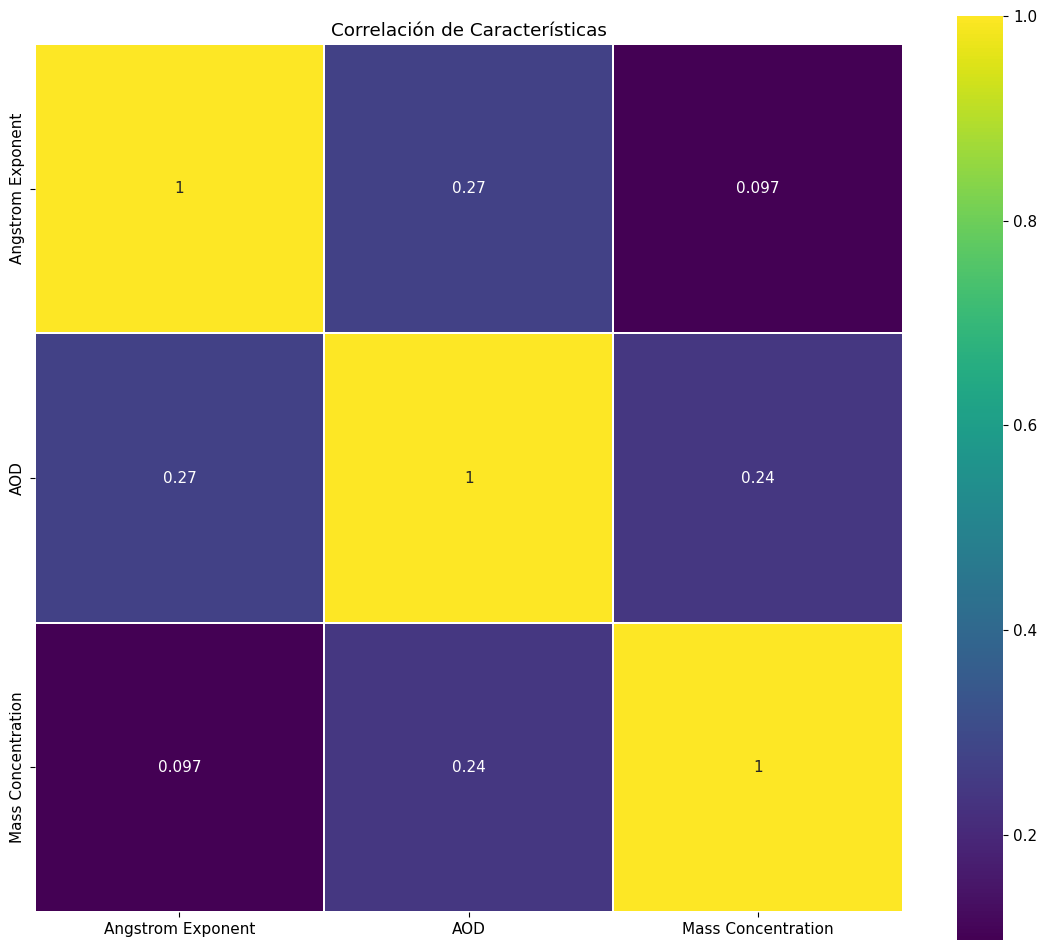

In [9]:
plt.title('Correlación de Características');
sb.heatmap(dfMeasures.astype(float).corr(), 
           linewidths=0.1, 
           vmax=1.0, 
           square=True, 
           cmap='viridis', 
           linecolor='white', 
           annot=True);

plt.savefig('correlacion.png')

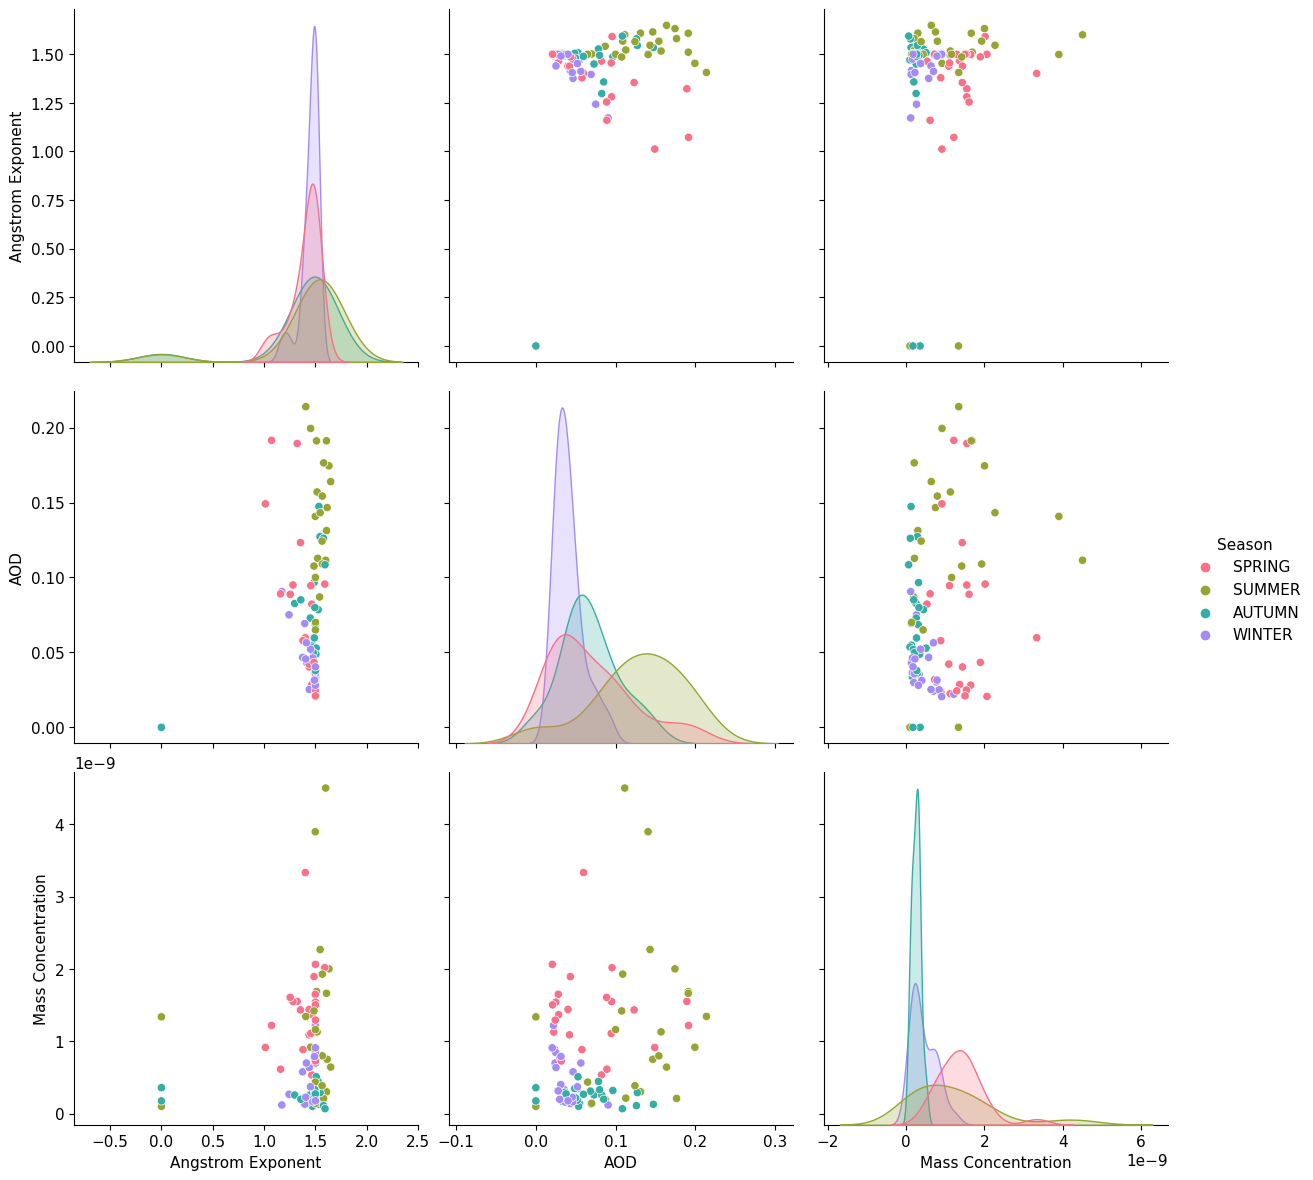

In [10]:
sb.pairplot(comb_df.dropna(), hue = 'Season', height = 4, vars = ['Angstrom Exponent','AOD','Mass Concentration'], kind = 'scatter', palette = 'husl');
#plt.title('Distribución de la Correlación de Características',  loc='right');
plt.savefig('correlacion-scatter.png')

In [ ]:
copyDf = comb_df.copy()
seasonTrgt = copyDf[['Season']]

In [ ]:
seasonTrgt.loc[seasonTrgt['Season'] == 'SPRING'] = 1
seasonTrgt.loc[seasonTrgt['Season'] == 'SUMMER'] = 2
seasonTrgt.loc[seasonTrgt['Season'] == 'AUTUMN'] = 3
seasonTrgt.loc[seasonTrgt['Season'] == 'WINTER'] = 4

In [ ]:
dfMeasures['SeasonTarget'] = seasonTrgt['Season']

In [ ]:
dfMeasures.to_csv('measures-2000-2005.csv')

In [ ]:
X = np.array(dfMeasures[['Angstrom Exponent','AOD','Mass Concentration']])
y = np.array(dfMeasures['SeasonTarget'])

In [ ]:
Xlab = np.array(dfMeasures[['Angstrom Exponent','AOD','Mass Concentration','SeasonTarget']])
fig = plt.figure()
ax = fig.gca(projection='3d')
cmap = ListedColormap(sb.color_palette("Spectral", 256 ).as_hex())
sc = ax.scatter(Xlab[:, 0], Xlab[:, 1], Xlab[:, 2], s=40, c=Xlab[:, 3], marker='o', cmap=cmap, alpha=1)
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc='best')
ax.set_xlabel('Angstrom Exponent')
ax.set_ylabel('Aerosol Optical Depth')
ax.set_zlabel('Mass Concentration')
plt.title('Dispersión de las Medidas');

plt.savefig('scatter-3D.png')

In [ ]:
#Aplicación del Modelo K-Means
kmeans = KMeans(n_clusters = 4).fit(X)
centroids = kmeans.cluster_centers_
print("Los valores de los centroides son: \n", centroids)

In [ ]:
#Etiquetas de cada punto de los datos
labels = kmeans.predict(X)

#Determinación de los centroides
C = kmeans.cluster_centers_
colores = ['red','green','blue','black']
asignar = []
for row in labels:
    asignar.append(colores[row])

#Gráfico 3D
fig = plt.figure()
ax = Axes3D(fig)
plt.title('Modelo KMeans con 4 Clusters');
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c = asignar, s = 60);
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker = '*', c = colores, s = 1000);
ax.set_xlabel('Angstrom Exponent')
ax.set_ylabel('Aerosol Optical Depth')
ax.set_zlabel('Mass Concentration')

plt.savefig('4clusters-3D.png')